In [1]:
import os
import numpy as np
import pandas as pd
import rasterio as rio
import geopandas as gpd
from rasterio.plot import show
import seaborn as sns
import matplotlib.pyplot as plt

## Necessary functions

In [2]:
# Codes for outlier range calculation using IQR and 
def makedirs(directory_list):
    """
    Make directory (if not exists) from a list of directory.

    :param directory_list: A list of directories to create.

    :return: None.
    """
    for directory in directory_list:
        if not os.path.exists(directory):
            os.makedirs(directory)

def read_raster_arr_object(raster_file, rasterio_obj=False, band=1, get_file=True, change_dtype=True):
    """
    Get raster array and raster file.

    :param raster_file: Input raster filepath.
    :param rasterio_obj: Set True if raster_file is a rasterio object.
    :param band: Selected band to read. Default set to 1.
    :param get_file: Set to False if raster file is not required.
    :param change_dtype: Set to True if want to change raster data type to float. Default set to True.

    :return: Raster numpy array and rasterio object file (get_file=True, rasterio_obj=False).
    """
    if not rasterio_obj:
        raster_file = rio.open(raster_file)
    else:
        get_file = False
    raster_arr = raster_file.read(band)
    if change_dtype:
        raster_arr = raster_arr.astype(np.float32)
        if raster_file.nodata:
            raster_arr[np.isclose(raster_arr, raster_file.nodata)] = np.nan
    if get_file:
        return raster_arr, raster_file
    else:
        return raster_arr

def calc_outlier_ranges_IQR(data, axis=None, decrease_lower_range_by=None, increase_upper_range_by=None):
    """
    calculate lower and upper range of outlier detection using IQR method.

    :param data: An array or list. Flattened array or list is preferred. If not flattened, adjust axis argument or
                 preprocess data before giving ito this function.
    :param axis: Axis or axes along which the percentiles are computed. Default set to None for flattened array or list.
    :param decrease_lower_range_by: A user-defined value to decrease lower range of outlier detection.
                                    Default set to None.
    :param increase_upper_range_by: A user-defined value to increase upper range of outlier detection.
                                    Default set to None.

    :return: lower_range, upper_range values of outlier detection.
    """
    q1 = np.nanpercentile(data, 25, axis=axis)
    median = np.nanpercentile(data, 50, axis=axis)
    q3 = np.nanpercentile(data, 75, axis=axis)

    iqr = q3 - q1

    lower_range = np.nanmin([i for i in data if i >= (q1 - 1.5 * iqr)])
    upper_range = np.nanmax([i for i in data if i <= (q3 + 1.5 * iqr)])

    # adjusts lower and upper values by an author-defined range
    if (decrease_lower_range_by is not None) | (increase_upper_range_by is not None):
        if (decrease_lower_range_by is not None) & (increase_upper_range_by is None):
            lower_range = lower_range - decrease_lower_range_by

        elif (increase_upper_range_by is not None) & (decrease_lower_range_by is None):
            upper_range = upper_range + increase_upper_range_by

        elif (increase_upper_range_by is not None) & (decrease_lower_range_by is not None):
            lower_range = lower_range - decrease_lower_range_by
            upper_range = upper_range + increase_upper_range_by

    return lower_range, upper_range, median


def calc_outlier_ranges_MAD(data, axis=None, threshold=3):
    """
    calculate lower and upper range of outlier detection using Median Absolute Deviation (MAD) method.

    A good paper on MAD-based outlier detection:
    https://www.sciencedirect.com/science/article/pii/S0022103113000668

    :param data: An array or list. Flattened array or list is preferred. If not flattened, adjust axis argument or
                 preprocess data before giving ito this function.
    :param axis: Axis or axes along which the percentiles are computed. Default set to None for flattened array or list.
    :param threshold: Value of threshold to use in MAD method.

    :return: lower_range, upper_range values of outlier detection.
    """
    # Calculate the median along the specified axis
    median = np.nanmedian(data, axis=axis)

    # Calculate the absolute deviations from the median
    abs_deviation = np.abs(data - median)

    # Calculate the median of the absolute deviations
    MAD = np.nanmedian(abs_deviation, axis=axis)

    lower_range = median - threshold * MAD
    upper_range = median + threshold * MAD

    return lower_range, upper_range, median


def scatter_plot_of_same_vars(Y_pred, Y_obsv, x_label, y_label, plot_name, savedir, alpha=0.03,
                              color_format='o', marker_size=0.5, title=None, axis_lim=None):
    """
    Makes scatter plot of model prediction vs observed data.

    :param Y_pred: flattened prediction array.
    :param Y_obsv: flattened observed array.
    :param x_label: Str of x label.
    :param y_label: Str of y label.
    :param plot_name: Str of plot name.
    :param savedir: filepath to save the plot.
    :param alpha: plot/scatter dots transparency level.
    :param marker_size: (float or int) Marker size.
    :param color_format: Color and plot type format. For example, for 'bo' 'b' means blue color and 'o' means dot plot.
    :param title: Str of title. Default set to None.
    :param axis_lim: A list of minimum and maximum values of x and y axis.
                     Default set to None (will calculate and set xlim, ylim itself)

    :return: A scatter plot of model prediction vs observed data.
    """
    # calculating min and max value ranges of the variables
    min_value = min(Y_pred.min(), Y_obsv.min())
    max_value = max(Y_pred.max(), Y_obsv.max())

    plt.rcParams.update({'font.size': 16})
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(Y_obsv, Y_pred, color_format, alpha=alpha, markersize=marker_size)
    ax.plot([0, 1], [0, 1], '-r', transform=ax.transAxes)
    ax.set_xlabel(x_label)  # 'Observed'
    ax.set_ylabel(y_label)  # 'Predicted'

    if axis_lim:
        ax.set_xlim(axis_lim)
        ax.set_ylim(axis_lim)
    else:
        ax.set_xlim([min_value, max_value])
        ax.set_ylim([min_value, max_value])

    if title is not None:
        ax.set_title(title)

    if '.tif' not in plot_name:
        plot_name = plot_name + '.tif'

    fig_loc = os.path.join(savedir, plot_name)
    fig.savefig(fig_loc, dpi=300)


def density_grid_plot_of_same_vars(Y_pred, Y_obsv, x_label, y_label, plot_name, savedir, bins=80,
                                   title=None, axis_lim=None):
    """
    Makes density grid plot for model prediction vs observed data. In the density grid plot, each grid represents a bin
    and each bin value represents the number/fraction of point in that bin.

    :param Y_pred: flattened prediction array.
    :param Y_obsv: flattened observed array.
    :param x_label: Str of x label.
    :param y_label: Str of y label.
    :param plot_name: Str of plot name.
    :param savedir: filepath to save the plot.
    :param bins: Numbers of bins to consider while binning for density grid. Default set to 80.
    :param title: Str of title. Default set to None.
    :param axis_lim: A list of minimum and maximum values of x and y axis.
                     Default set to None (will calculate and set xlim, ylim itself)

    :return: A scatter plot of model prediction vs observed data.
    """
    # calculating min and max value ranges of the variables
    min_value = min(Y_pred.min(), Y_obsv.min())
    max_value = max(Y_pred.max(), Y_obsv.max())

    # creating a density grid for the dataset where each point belongs to a bin. The outputs of the np.histogram2d are
    # numpy arrays
    heatmap, xedges, yedges = np.histogram2d(Y_obsv, Y_pred, bins=bins, density=False)
    print(heatmap.shape)
    print(xedges.shape)
    print(yedges.shape)
    
    plt.rcParams.update({'font.size': 16})
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the density grid as a heatmap
    density_plot = ax.imshow(heatmap, origin='lower', extent=[min_value, max_value, min_value, max_value],
                             cmap='RdYlBu_r')
    ax.set_xlabel(x_label)  # 'Observed'
    ax.set_ylabel(y_label)  # 'Predicted'
    ax.plot([0, 1], [0, 1], '-r', transform=ax.transAxes)
    fig.colorbar(label='Number of samples in each bin', mappable=density_plot)

    if axis_lim:
        ax.set_xlim(axis_lim)
        ax.set_ylim(axis_lim)
    else:
        ax.set_xlim([min_value, max_value])
        ax.set_ylim([min_value, max_value])

    if title is not None:
        ax.set_title(title)

    if '.tif' not in plot_name:
        plot_name = plot_name + '.tif'

    fig.savefig(plot_name, dpi=300)

def scatter_plot(X, Y, x_label, y_label, plot_name, savedir, alpha=0.03,
                  color_format='o', marker_size=0.5, title=None):
    """
    Makes scatter plot between 2 variables.

    :param X: Variable array in x axis.
    :param Y: Variable array in y axis.
    :param x_label: Str of x label.
    :param y_label: Str of y label.
    :param plot_name: Str of plot name.
    :param savedir: filepath to save the plot.
    :param alpha: plot/scatter dots transparency level.
    :param marker_size: (float or int) Marker size.
    :param color_format: Color and plot type format. For example, for 'bo' 'b' means blue color and 'o' means dot plot.
    :param title: Str of title. Default set to None.
    :param axis_lim: A list of minimum and maximum values of x and y axis.
                     Default set to None (will calculate and set xlim, ylim itself)

    :return: A scatter plot of model prediction vs observed data.
    """
    plt.rcParams.update({'font.size': 16})
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(X, Y, color_format, alpha=alpha, markersize=marker_size)
    ax.plot([0, 1], [0, 1], '-r', transform=ax.transAxes)
    ax.set_xlabel(x_label)  # 'Observed'
    ax.set_ylabel(y_label)  # 'Predicted'

    if title is not None:
        ax.set_title(title)

    if savedir is not None:
        makedirs([savedir])

        if '.tif' not in plot_name:
            plot_name = plot_name + '.tif'

        fig_loc = os.path.join(savedir, plot_name)
        fig.savefig(fig_loc, dpi=300)

## USDA CDL crop classification

In [3]:
USDA_cdl_class_df = pd.read_csv('F:\WestUS_NetGW\Data_main\Data_Drivers_of_ET/USDA_cdl_classification.csv')
USDA_cdl_class_df = USDA_cdl_class_df.set_index(keys='Class')
USDA_cdl_class_df.head()

,Crop,min_wrq,avg_wrq,max_wrq
Class,,,,
1,Corn,600.0,680.0,760.0
2,Cotton,700.0,1000.0,1300.0
3,Rice,450.0,575.0,700.0
4,Sorghum,530.0,680.0,830.0
5,Soybeans,450.0,600.0,750.0


In [4]:
# making the df to a dictionary
usda_cdl_dict = USDA_cdl_class_df.to_dict()
usda_cdl_dict = usda_cdl_dict['Crop']
usda_cdl_dict

{1: 'Corn',
 2: 'Cotton',
 3: 'Rice',
 4: 'Sorghum',
 5: 'Soybeans',
 6: 'Sunflower',
 10: 'Peanuts',
 11: 'Tobacco',
 12: 'Sweet Corn',
 13: 'Pop or Orn Corn',
 14: 'Mint',
 21: 'Barley',
 22: 'Durum Wheat',
 23: 'Spring Wheat',
 24: 'Winter Wheat',
 25: 'Other Small Grains',
 26: 'Dbl Crop WinWht/Soybeans',
 27: 'Rye',
 28: 'Oats',
 29: 'Millet',
 30: 'Speltz',
 31: 'Canola',
 32: 'Flaxseed',
 33: 'Safflower',
 34: 'Rape Seed',
 35: 'Mustard',
 36: 'Alfalfa',
 37: 'Other Hay/Non Alfalfa',
 38: 'Camelina',
 39: 'Buckwheat',
 41: 'Sugarbeets',
 42: 'Dry Beans',
 43: 'Potatoes',
 44: 'Other Crops',
 45: 'Sugarcane',
 46: 'Sweet Potatoes',
 47: 'Misc Vegs & Fruits',
 48: 'Watermelons',
 49: 'Onions',
 50: 'Cucumbers',
 51: 'Chick Peas',
 52: 'Lentils',
 53: 'Peas',
 54: 'Tomatoes',
 55: 'Caneberries',
 56: 'Hops',
 57: 'Herbs',
 58: 'Clover/Wildflowers',
 59: 'Sod/Grass Seed',
 60: 'Switchgrass',
 61: 'Fallow/Idle Cropland',
 63: 'Forest',
 64: 'Shrubland',
 65: 'Barren',
 66: 'Cherries'

------------------------

# Relation betweeen Total ET, Min Temperature, and tree cover 
I am curious to find out whether high ET in Southwest part of OK and TX is due to high average monthly minimum temperature. ALso, whether tree cover has impacts on ET.

In [5]:
et_data = '../../scratch/some_states_datasets/total_ET_some_states_2016_6.tif'
tmin_data = '../../scratch/some_states_datasets/tmin_some_states_2016_6.tif'
tree_cover_data = '../../scratch/some_states_datasets/tree_cover_some_states.tif'
some_states = '../../scratch/some_states_datasets/some_states.shp'
NE_KS_ROI = '../../scratch/some_states_datasets/ROI_NE_KS.shp'

<AxesSubplot:>

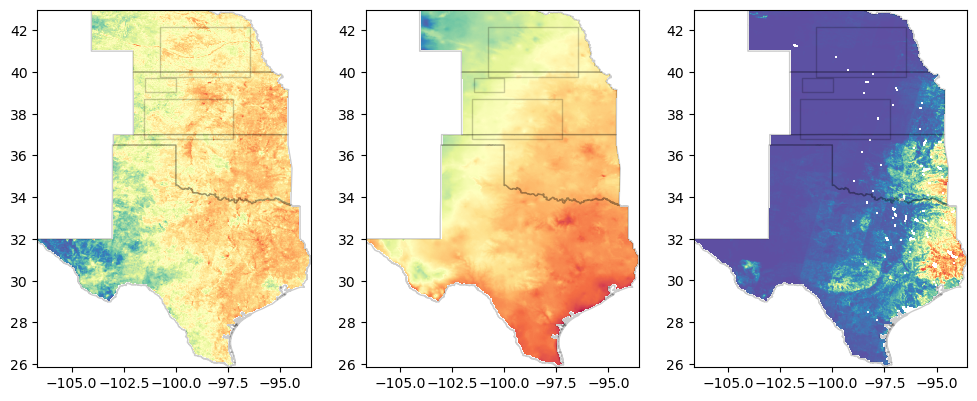

In [6]:
et_file= rio.open(et_data)
tmin_file = rio.open(tmin_data)
tree_file = rio.open(tree_cover_data)
some_states_df = gpd.read_file(some_states)
NE_KS_ROI_df = gpd.read_file(NE_KS_ROI)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))

some_states_df.plot(facecolor='none', edgecolor='black', alpha=0.2, ax=ax[0])
NE_KS_ROI_df.plot(facecolor='none', edgecolor='black', alpha=0.2, ax=ax[0])
show(et_file, ax=ax[0], cmap='Spectral_r')

some_states_df.plot(facecolor='none', edgecolor='black', alpha=0.2, ax=ax[1])
NE_KS_ROI_df.plot(facecolor='none', edgecolor='black', alpha=0.2, ax=ax[1])
show(tmin_file, ax=ax[1], cmap='Spectral_r')

some_states_df.plot(facecolor='none', edgecolor='black', alpha=0.2, ax=ax[2])
NE_KS_ROI_df.plot(facecolor='none', edgecolor='black', alpha=0.2, ax=ax[2])
show(tree_file, ax=ax[2], cmap='Spectral_r')

Looks like southwest OK and TX has higher minimun average monthly temperature than our ROI in NE and KS. Also, the eastern part of KS, OK, and TX have higher tree cover, leading to higher total ET.

## Does ET and minimum temperature has a linear relationship?

In [7]:
et_arr= rio.open(et_data).read(1).flatten()
tmin_arr = rio.open(tmin_data).read(1).flatten()

et_arr.shape

(562848,)

In [8]:
nan_rmv_et_arr = []
nan_rmv_tmin_arr = []

for i, j in zip(list(et_arr), list(tmin_arr)):
    if (i != -9999) and (j != -9999):
        nan_rmv_et_arr.append(i)
        nan_rmv_tmin_arr.append(j)

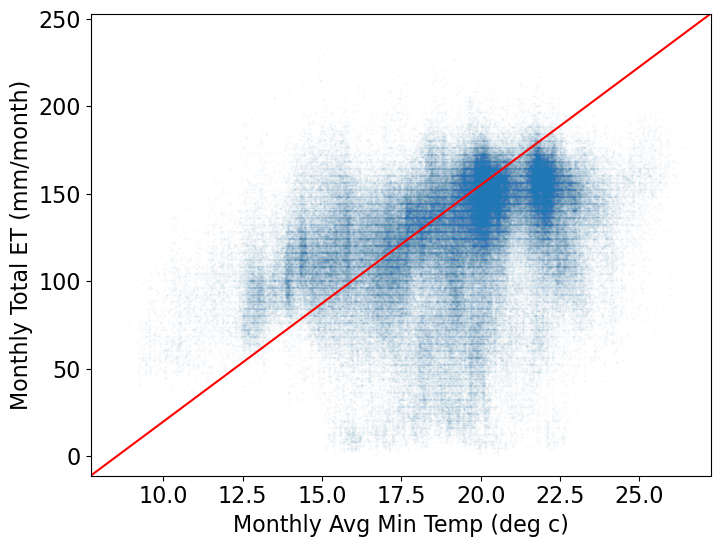

In [9]:
scatter_plot(X=nan_rmv_tmin_arr, Y=nan_rmv_et_arr, x_label='Monthly Avg Min Temp (deg c)', y_label='Monthly Total ET (mm/month)', 
             plot_name=None, savedir=None, alpha=0.03,
                  color_format='o', marker_size=0.5, title=None)

Minimum temperature and total ET seem to have a linear trend. High min temperature might be a reason of high ET even from rainfed regions in OK and TX.

-------------------------

In [10]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Is ET more correlated to precipitation or Irrigation in Kansas GMD?

### ET vs Precip : GMD, KS (Irrigated)

In [11]:
gmd_mnth_df = pd.read_csv('../../Data_main/Data_Drivers_of_ET/CSVs/GMD_KS_irrig_monthly.csv')
gmd_mnth_df.columns

Index(['OpenET', 'year', 'month', 'PRISM_PPT', 'USDA_CDL'], dtype='object')

In [12]:
x = gmd_mnth_df[['PRISM_PPT']]
y = gmd_mnth_df[['OpenET']]

#train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, shuffle=True)
x_train, x_test, y_train, y_test = x_train.values, x_test.values, y_train.values, y_test.values

# linear model
lm = LinearRegression()
lm_trained = lm.fit(x_train, y_train)
lm_trained.coef_

array([[0.1881166]])

Coefficient of determination: 0.10


Text(0, 0.5, 'Monthly OpenET (mm)')

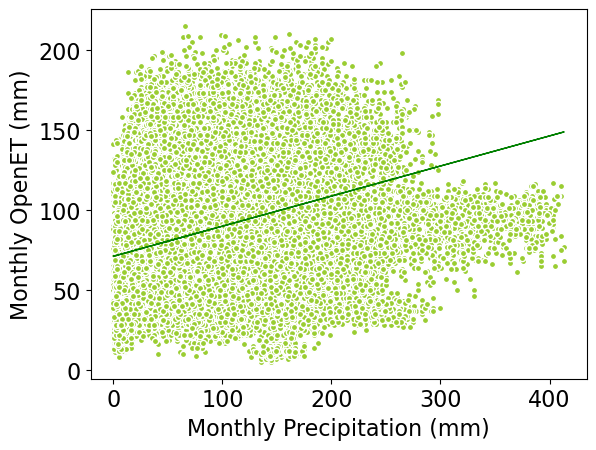

In [13]:
# R2 
y_test_pred = lm_trained.predict(x_test)
r2 = r2_score(y_test, y_test_pred)

# plot performance
print("Coefficient of determination: %.2f" % r2)
plt.scatter(x_test, y_test, facecolor='yellowgreen', edgecolor='white', s=20,)
plt.plot(x_test, y_test_pred, color='green', linewidth=1)
plt.xlabel('Monthly Precipitation (mm)')
plt.ylabel('Monthly OpenET (mm)')

### ET vs Precip : KS (Rainfed)

In [14]:
gmd_mnth_df = pd.read_csv('../../Data_main/Data_Drivers_of_ET/CSVs/KS_rain_monthly.csv')
gmd_mnth_df.columns

Index(['OpenET', 'year', 'month', 'PRISM_PPT', 'USDA_CDL'], dtype='object')

In [15]:
x = gmd_mnth_df[['PRISM_PPT']]
y = gmd_mnth_df[['OpenET']]

#train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, shuffle=True)
x_train, x_test, y_train, y_test = x_train.values, x_test.values, y_train.values, y_test.values

# linear model
lm = LinearRegression()
lm_trained = lm.fit(x_train, y_train)
lm_trained.coef_

array([[0.09284546]])

Coefficient of determination: 0.04


Text(0, 0.5, 'Monthly OpenET (mm)')

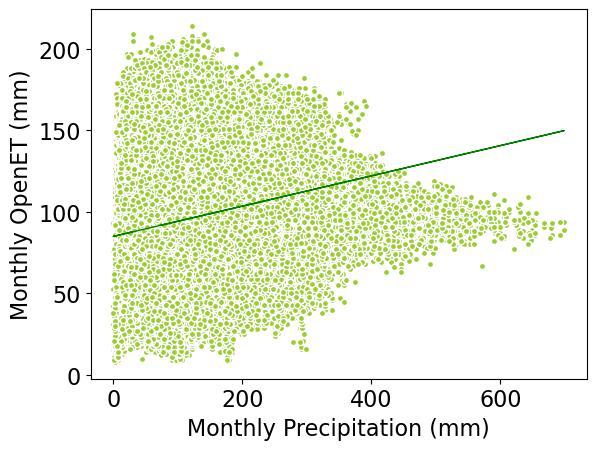

In [16]:
# R2 
y_test_pred = lm_trained.predict(x_test)
r2 = r2_score(y_test, y_test_pred)

# plot performance
print("Coefficient of determination: %.2f" % r2)
plt.scatter(x_test, y_test, facecolor='yellowgreen', edgecolor='white', s=20,)
plt.plot(x_test, y_test_pred, color='green', linewidth=1)
plt.xlabel('Monthly Precipitation (mm)')
plt.ylabel('Monthly OpenET (mm)')

Monthly ET responses similary to monthly precipitation in Kansas in both Irrigated and Rainfed croplands. This means __irrigation has minimal to no effect on ET__. To prove this hypothesis, we compare annual ET with annual irrigation and annual pumping.

### Annual ET vs Irrigation : GMD, KS (Irrigated)

In [17]:
gmd_df = pd.read_csv('../../Data_main/Data_drivers_of_ET/KS_GW.csv')
gmd_df.columns

Index(['Acres', 'CDL', 'GPM_PPT', 'OBJECTID', 'PDIV_ID', 'PRISM_PPT',
       'PRISM_TMAX', 'SSEBop', 'TC_PPT', 'TC_RO', 'TC_SM', 'TC_TMAX', 'WU_AF',
       'WU_mm', 'Year', 'gmd', 'lat_nad83', 'long_nad83', 'FREQUENCY', 'Crop'],
      dtype='object')

In [18]:
x = gmd_df[['WU_mm']]
y = gmd_df[['SSEBop']]

# train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, shuffle=True)
x_train, x_test, y_train, y_test = x_train.values, x_test.values, y_train.values, y_test.values

# linear model
lm = LinearRegression()
lm_trained = lm.fit(x_train, y_train)
lm_trained.coef_

array([[-0.23138859]])

Coefficient of determination: 0.10


Text(0, 0.5, 'Annual SSEBop ET (mm)')

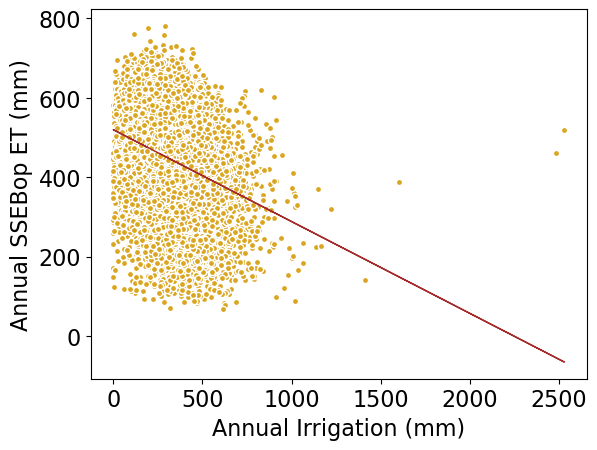

In [19]:
# R2
y_test_pred = lm_trained.predict(x_test)
r2 = r2_score(y_test, y_test_pred)

# plot performance
print("Coefficient of determination: %.2f" % r2)
plt.scatter(x_test, y_test, facecolor='goldenrod', edgecolor='white', s=20)
plt.plot(x_test, y_test_pred, color="brown", linewidth=1)
plt.xlabel('Annual Irrigation (mm)')
plt.ylabel('Annual SSEBop ET (mm)')

Looks like annual ET is negatively correlated to Irrigation 

### Annual ET vs Precipitation : GMD, KS (Irrigated)

In [20]:
x = gmd_df[['PRISM_PPT']]
y = gmd_df[['SSEBop']]

# train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, shuffle=True)
x_train, x_test, y_train, y_test = x_train.values, x_test.values, y_train.values, y_test.values
y_train

# linear model
lm = LinearRegression()
lm_trained = lm.fit(x_train, y_train)
lm_trained.coef_

array([[0.67886196]])

Coefficient of determination: 0.41


Text(0, 0.5, 'Annual SSEBop ET (mm)')

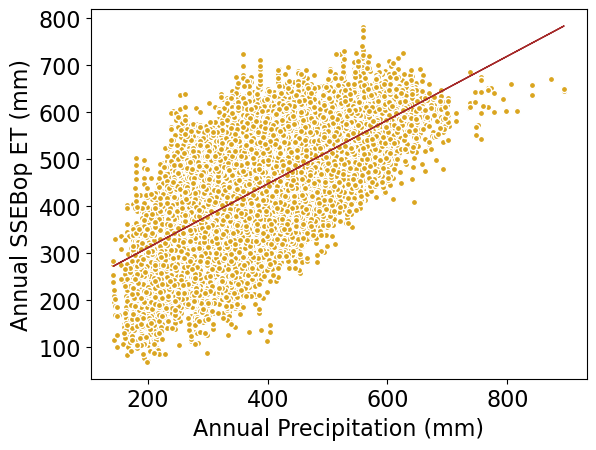

In [21]:
# R2
y_test_pred = lm_trained.predict(x_test)
r2 = r2_score(y_test, y_test_pred)

# plot performance
print("Coefficient of determination: %.2f" % r2)
plt.scatter(x_test, y_test, facecolor='goldenrod', edgecolor='white', s=20,)
plt.plot(x_test, y_test_pred, color='brown', linewidth=1)
plt.xlabel('Annual Precipitation (mm)')
plt.ylabel('Annual SSEBop ET (mm)')

Looks like in Kansas GMD, Annual ET is driven more by precipitation than Irrigation annualy, proving our hypothesis __irrigation has minimal to no effect on ET__ in Kansas. We are going to test whether this is only true for sub-humid region like Kansas. So, we will compare monthly (growing season) ET vs precipitation in Central Valley, California.

### ET vs Precip : Central Valley, CA (Irrigated)

In [22]:
cv_mnth_df = pd.read_csv('../../Data_main/Data_Drivers_of_ET/CSVs/CV_CA_irrig_monthly.csv')
cv_mnth_df.columns

Index(['OpenET', 'year', 'month', 'PRISM_PPT', 'USDA_CDL'], dtype='object')

In [23]:
x = cv_mnth_df[['PRISM_PPT']]
y = cv_mnth_df[['OpenET']]

#train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, shuffle=True)
x_train, x_test, y_train, y_test = x_train.values, x_test.values, y_train.values, y_test.values

# linear model
lm = LinearRegression()
lm_trained = lm.fit(x_train, y_train)
lm_trained.coef_

array([[-0.40102542]])

Coefficient of determination: 0.03


Text(0, 0.5, 'Monthly OpenET (mm)')

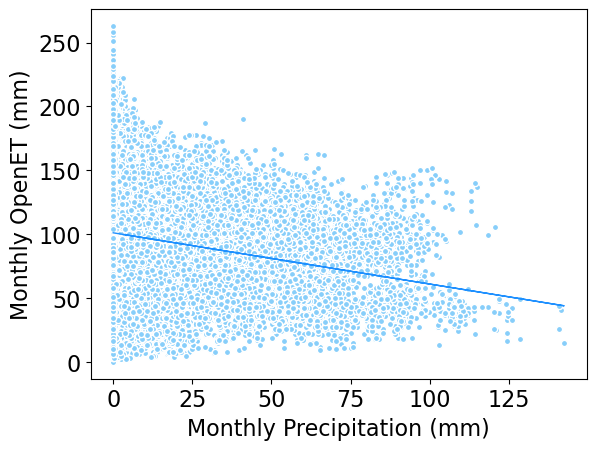

In [24]:
# R2 
y_test_pred = lm_trained.predict(x_test)
r2 = r2_score(y_test, y_test_pred)

# plot performance
print("Coefficient of determination: %.2f" % r2)
plt.scatter(x_test, y_test, facecolor='lightskyblue', edgecolor='white', s=20,)
plt.plot(x_test, y_test_pred, color='dodgerblue', linewidth=1)
plt.xlabel('Monthly Precipitation (mm)')
plt.ylabel('Monthly OpenET (mm)')

In central valley, irrigated croplands ET has negative correlation with precipitation. That means __something else (irrigation)__ is the controlling factor of ET.

### ET vs Precip : Central Valley, CA (Rainfed)

In [25]:
cv_mnth_df = pd.read_csv('../../Data_main/Data_Drivers_of_ET/CSVs/CV_CA_rain_monthly.csv')
cv_mnth_df.columns

Index(['OpenET', 'year', 'month', 'PRISM_PPT', 'USDA_CDL'], dtype='object')

In [26]:
x = cv_mnth_df[['PRISM_PPT']]
y = cv_mnth_df[['OpenET']]

#train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, shuffle=True)
x_train, x_test, y_train, y_test = x_train.values, x_test.values, y_train.values, y_test.values

# linear model
lm = LinearRegression()
lm_trained = lm.fit(x_train, y_train)
lm_trained.coef_

array([[0.35507755]])

Coefficient of determination: 0.06


Text(0, 0.5, 'Monthly OpenET (mm)')

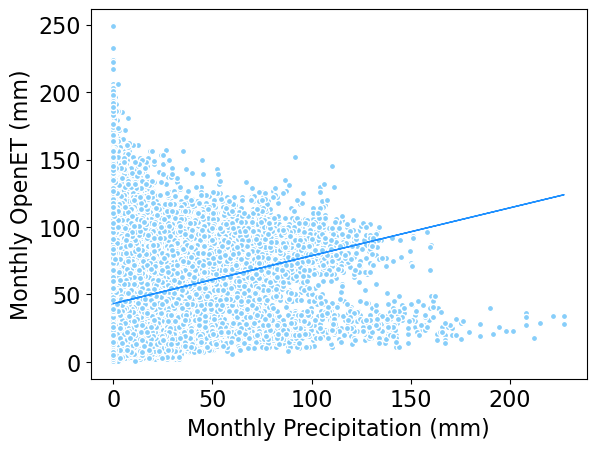

In [27]:
# R2 
y_test_pred = lm_trained.predict(x_test)
r2 = r2_score(y_test, y_test_pred)

# plot performance
print("Coefficient of determination: %.2f" % r2)
plt.scatter(x_test, y_test, facecolor='lightskyblue', edgecolor='white', s=20,)
plt.plot(x_test, y_test_pred, color='dodgerblue', linewidth=1)
plt.xlabel('Monthly Precipitation (mm)')
plt.ylabel('Monthly OpenET (mm)')

In rainfed pasture lands buffer around Central Valley, monthly ET reponses positively to monthly precipitation. But the higher ET than precipitation (top left corner) of the plot suggest, there might be high ET at months when there is no precip. We recommend using the term __"effective precipitation"__ (remainder precip after deep percolation and surface runoff, and water from soil storage supplied by precip from previous months/year) in this case.

# How ET varies with crop type

## GMD KS: irrigated vs rainfed

In [5]:
# Irrigated (GMD)
gmd_mnth_df_irrig = pd.read_csv('../../Data_main/Data_Drivers_of_ET/CSVs/GMD_KS_irrig_monthly.csv')
gmd_mnth_df_irrig['Crop'] = gmd_mnth_df_irrig['USDA_CDL'].map(usda_cdl_dict)
gmd_mnth_df_irrig = gmd_mnth_df_irrig[gmd_mnth_df_irrig['Crop'].isin(['Corn', 'Winter Wheat', 'Sorghum', 'Alfalfa', 'Soybeans'])]
gmd_mnth_df_irrig = gmd_mnth_df_irrig[gmd_mnth_df_irrig['month'].isin([6, 7, 8, 9])]

# Rainfed (outside GMD)
gmd_mnth_df_rain = pd.read_csv('../../Data_main/Data_Drivers_of_ET/CSVs/KS_rain_monthly.csv')
gmd_mnth_df_rain['Crop'] = gmd_mnth_df_rain['USDA_CDL'].map(usda_cdl_dict)
gmd_mnth_df_rain = gmd_mnth_df_rain[gmd_mnth_df_rain['Crop'].isin(['Corn', 'Winter Wheat', 'Sorghum', 'Alfalfa', 'Soybeans', 'Grassland/Pasture'])]
gmd_mnth_df_rain = gmd_mnth_df_rain[gmd_mnth_df_rain['month'].isin([6, 7, 8, 9])]

gmd_mnth_df_rain.head()

,OpenET,year,month,PRISM_PPT,USDA_CDL,Crop
76946,101.0,2016,6,50.434,176.0,Grassland/Pasture
76947,95.0,2016,6,50.434,176.0,Grassland/Pasture
76948,108.0,2016,6,63.281,176.0,Grassland/Pasture
76949,108.0,2016,6,63.281,176.0,Grassland/Pasture
76950,95.0,2016,6,72.013,176.0,Grassland/Pasture


(0.0, 300.0)

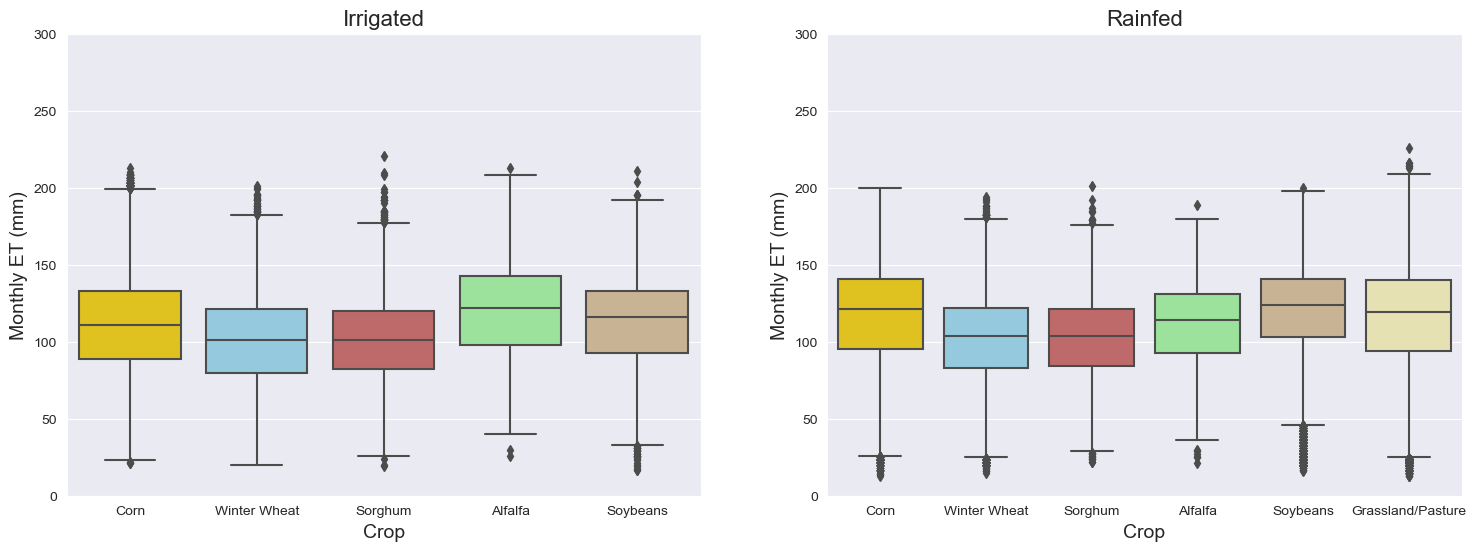

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.set_style("darkgrid")

# setting similar color palette for similar crops 
category_colors = {'Corn': 'gold', 'Winter Wheat': 'skyblue', 'Sorghum': 'indianred', 'Alfalfa': 'lightgreen', 
                          'Soybeans': 'tan', 'Grassland/Pasture': 'palegoldenrod'}

# category order
category_order_gmd = ['Corn', 'Winter Wheat', 'Sorghum', 'Alfalfa', 'Soybeans']
category_order_gmd_out = ['Corn', 'Winter Wheat', 'Sorghum', 'Alfalfa', 'Soybeans', 'Grassland/Pasture']

# irrigated
sns.boxplot(x=gmd_mnth_df_irrig['Crop'], y=gmd_mnth_df_irrig['OpenET'], ax=ax[0], palette=category_colors, order=category_order_gmd)
ax[0].set_xlabel('Crop', fontsize=14)
ax[0].set_ylabel('Monthly ET (mm)', fontsize=14)
ax[0].tick_params(axis='both', labelsize=10)
ax[0].set_title('Irrigated', fontsize=16)
ax[0].set_ylim(0, 300)

# rainfed
sns.boxplot(x=gmd_mnth_df_rain['Crop'], y=gmd_mnth_df_rain['OpenET'], ax=ax[1], palette=category_colors, order=category_order_gmd_out)
ax[1].set_xlabel('Crop', fontsize=14)
ax[1].set_ylabel('Monthly ET (mm)', fontsize=14)
ax[1].tick_params(axis='both', labelsize=10)
ax[1].set_title('Rainfed', fontsize=16)
ax[1].set_ylim(0, 300)

Almost similar growing season monthly ET for major crop types in GMD Kansas. __The pasture/grassland isn't irrigated still have similar ET to crops__.

## Central Valley CA: irrigated vs rainfed

In [8]:
# Irrigated (CV)
cv_mnth_df_irrig = pd.read_csv('../../Data_main/Data_Drivers_of_ET/CSVs/CV_CA_irrig_monthly.csv')
cv_mnth_df_irrig['Crop'] = cv_mnth_df_irrig['USDA_CDL'].map(usda_cdl_dict)
cv_mnth_df_irrig = cv_mnth_df_irrig[cv_mnth_df_irrig['Crop'].isin(['Corn', 'Rice', 'Alfalfa', 'Tomatoes', 'Grapes', 'Almonds', 'Walnuts'])]
cv_mnth_df_irrig = cv_mnth_df_irrig[cv_mnth_df_irrig['month'].isin([6, 7, 8, 9])]

# Rainfed (a buffer outside CV)
# almost all the crops in CV is irrigated. Rainfed areas mostly consists of Pasture/grassland
cv_mnth_df_rain = pd.read_csv('../../Data_main/Data_Drivers_of_ET/CSVs/CV_CA_rain_monthly.csv')
cv_mnth_df_rain['Crop'] = cv_mnth_df_rain['USDA_CDL'].map(usda_cdl_dict)
cv_mnth_df_rain = cv_mnth_df_rain[cv_mnth_df_rain['Crop'].isin(['Grassland/Pasture'])]
cv_mnth_df_rain = cv_mnth_df_rain[cv_mnth_df_rain['month'].isin([6, 7, 8, 9])]

cv_mnth_df_rain.head()

,OpenET,year,month,PRISM_PPT,USDA_CDL,Crop
12376,71.0,2016,6,55.546,176.0,Grassland/Pasture
12377,122.0,2016,6,53.878,176.0,Grassland/Pasture
12378,125.0,2016,6,53.878,176.0,Grassland/Pasture
12379,125.0,2016,6,55.546,176.0,Grassland/Pasture
12380,120.0,2016,6,55.546,176.0,Grassland/Pasture


In [9]:
cv_mnth_df_rain.Crop.unique()

array(['Grassland/Pasture'], dtype=object)

(0.0, 300.0)

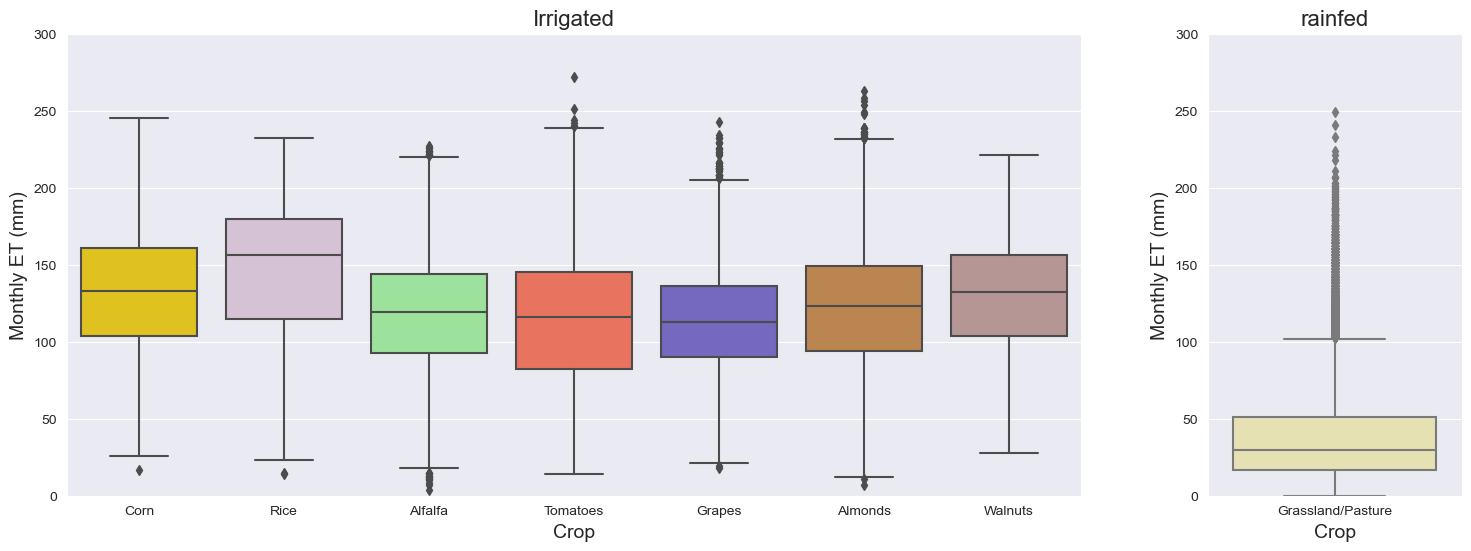

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [4, 1]})
sns.set_style("darkgrid")

# setting similar color palette for similar crops 
category_colors = {'Corn': 'gold', 'Rice': 'thistle', 'Tomatoes': 'tomato', 'Alfalfa': 'lightgreen', 
                      'Almonds': 'perU', 'Grapes': 'slateblue', 'Walnuts': 'rosybrown',  'Grassland/Pasture': 'palegoldenrod'}

# category order
category_order_cv = ['Corn', 'Rice', 'Alfalfa', 'Tomatoes', 'Grapes', 'Almonds', 'Walnuts']
category_order_cv_out = ['Grassland/Pasture']

# irrigated
sns.boxplot(x=cv_mnth_df_irrig['Crop'], y=cv_mnth_df_irrig['OpenET'], ax=ax[0], palette=category_colors, order=category_order_cv)
ax[0].set_xlabel('Crop', fontsize=14)
ax[0].set_ylabel('Monthly ET (mm)', fontsize=14)
ax[0].tick_params(axis='both', labelsize=10)
ax[0].set_title('Irrigated', fontsize=16)
ax[0].set_ylim(0, 300)

# rainfed
sns.boxplot(x=cv_mnth_df_rain['Crop'], y=cv_mnth_df_rain['OpenET'], ax=ax[1], palette=category_colors, order=category_order_cv_out)
ax[1].set_xlabel('Crop', fontsize=14)
ax[1].set_ylabel('Monthly ET (mm)', fontsize=14)
ax[1].tick_params(axis='both', labelsize=10)
ax[1].set_title('rainfed', fontsize=16)
ax[1].set_ylim(0, 300)

# Gap for Irrigation to fill

### GMD KS

In [11]:
# Converting crop class information to a dictionary
USDA_cdl_class_df = pd.read_csv('F:\WestUS_NetGW\Data_main\Data_Drivers_of_ET/USDA_cdl_classification.csv')
USDA_cdl_class_df = USDA_cdl_class_df.set_index('Class')
usda_cdl_dict_crop = USDA_cdl_class_df.to_dict()['Crop']
# usda_cdl_dict_crop

In [12]:
# Irrigated (GMD)
gmd_year_df_irrig = pd.read_csv('../../Data_main/Data_Drivers_of_ET/CSVs/GMD_KS_irrig_yearly.csv')
gmd_year_df_irrig['Crop'] = gmd_year_df_irrig['USDA_CDL'].map(usda_cdl_dict_crop)
gmd_year_df_irrig = gmd_year_df_irrig[gmd_year_df_irrig['Crop'].isin(['Corn', 'Winter Wheat', 'Sorghum', 'Alfalfa', 'Soybeans'])]
print(gmd_year_df_irrig.head())

# Groupby Operation
summary_df_KS = gmd_year_df_irrig.groupby(by='Crop', axis=0).aggregate({'PRISM_PPT': ['min', 'median', 'max'],
                                                                           'OpenET': ['min', 'median', 'max'],
                                                                           'GRIDMET_RET': ['min', 'median', 'max']})
summary_df_KS = summary_df_KS.reset_index()
summary_df_KS

    OpenET  PRISM_PPT  GRIDMET_RET  USDA_CDL          Crop
1    639.0  681.15906     1261.230       1.0          Corn
25   626.0  555.90600     1247.630      24.0  Winter Wheat
26   625.0  578.75500     1247.630       1.0          Corn
27   624.0  578.75500     1247.630      24.0  Winter Wheat
28   659.0  603.97200     1253.155      24.0  Winter Wheat


Crop  PRISM_PPT                           OpenET                 \
                       min     median        max        min median     max   
0       Alfalfa  242.08598  637.08300  1161.8030  437.00000  846.0  1213.0   
1          Corn  224.51201  607.70400  1191.8530  393.59820  739.0  1065.0   
2       Sorghum  207.39300  612.87900  1168.3291  346.00000  708.0  1075.0   
3      Soybeans  315.39703  758.23694  1280.4140  502.00000  792.0  1039.0   
4  Winter Wheat  233.98799  662.25500  1188.6120  351.76926  735.0  1125.0   

  GRIDMET_RET                        
          min     median        max  
0   1061.4800  1348.0150  1475.4300  
1   1051.9601  1307.0450  1624.5200  
2   1066.9200  1355.9200  1619.5901  
3   1052.0450  1219.3675  1451.2902  
4   1051.2800  1298.0352  1580.0650

In [13]:
# Converting crop class, min/ mean/ max seasonal water requirement information to a dictionary
USDA_cdl_class_df = pd.read_csv('F:\WestUS_NetGW\Data_main\Data_Drivers_of_ET/USDA_cdl_classification.csv')
print(USDA_cdl_class_df.columns)
USDA_cdl_class_df = USDA_cdl_class_df.set_index('Crop')
usda_cdl_dict = USDA_cdl_class_df.to_dict()
# usda_cdl_dict

Index(['Class', 'Crop', 'min_wrq', 'avg_wrq', 'max_wrq'], dtype='object')


In [14]:
# Adding crop water requirement columns from USDA CDL dataframe
summary_df_KS['min_season_wrq'] = summary_df_KS['Crop'].map(usda_cdl_dict['min_wrq'])
summary_df_KS['mean_season_wrq'] = summary_df_KS['Crop'].map(usda_cdl_dict['avg_wrq'])
summary_df_KS['max_season_wrq'] = summary_df_KS['Crop'].map(usda_cdl_dict['max_wrq'])
summary_df_KS

Crop  PRISM_PPT                           OpenET                 \
                       min     median        max        min median     max   
0       Alfalfa  242.08598  637.08300  1161.8030  437.00000  846.0  1213.0   
1          Corn  224.51201  607.70400  1191.8530  393.59820  739.0  1065.0   
2       Sorghum  207.39300  612.87900  1168.3291  346.00000  708.0  1075.0   
3      Soybeans  315.39703  758.23694  1280.4140  502.00000  792.0  1039.0   
4  Winter Wheat  233.98799  662.25500  1188.6120  351.76926  735.0  1125.0   

  GRIDMET_RET                       min_season_wrq mean_season_wrq  \
          min     median        max                                  
0   1061.4800  1348.0150  1475.4300          500.0           825.0   
1   1051.9601  1307.0450  1624.5200          600.0           680.0   
2   1066.9200  1355.9200  1619.5901          530.0           680.0   
3   1052.0450  1219.3675  1451.2902          450.0           600.0   
4   1051.2800  1298.0352  1580.0650          400.0           450.0   

  max_season_wrq  
                  
0         1150.0  
1          760.0  
2          830.0  
3          750.0  
4          500.0

### Central Valley CA

In [15]:
# Converting crop class information to a dictionary
USDA_cdl_class_df = pd.read_csv('F:\WestUS_NetGW\Data_main\Data_Drivers_of_ET/USDA_cdl_classification.csv')
USDA_cdl_class_df = USDA_cdl_class_df.set_index('Class')
usda_cdl_dict_crop = USDA_cdl_class_df.to_dict()['Crop']
# usda_cdl_dict_crop

In [16]:
# Irrigated (CV)
cv_year_df_irrig = pd.read_csv('../../Data_main/Data_Drivers_of_ET/CSVs/CV_CA_irrig_yearly.csv')
cv_year_df_irrig['Crop'] = cv_year_df_irrig['USDA_CDL'].map(usda_cdl_dict_crop)
cv_year_df_irrig = cv_year_df_irrig[cv_year_df_irrig['Crop'].isin(['Corn', 'Rice', 'Alfalfa', 'Tomatoes', 'Grapes', 'Almonds', 'Walnuts'])]
print(cv_year_df_irrig.head())

# Groupby Operation
summary_df_CA = cv_year_df_irrig.groupby(by='Crop', axis=0).aggregate({'PRISM_PPT': ['min', 'median', 'max'],
                                                                           'OpenET': ['min', 'median', 'max'],
                                                                           'GRIDMET_RET': ['min', 'median', 'max']})
summary_df_CA = summary_df_CA.reset_index()
summary_df_CA

    OpenET  PRISM_PPT  GRIDMET_RET  USDA_CDL     Crop
3   1271.0  835.32697    1458.4299      76.0  Walnuts
4   1122.0  835.32697    1458.4299      76.0  Walnuts
5   1098.0  865.79400    1453.2450      76.0  Walnuts
11  1211.0  835.32697    1458.4299      76.0  Walnuts
12  1065.0  865.79400    1453.2450      76.0  Walnuts


Crop  PRISM_PPT                            OpenET                  \
                   min     median         max        min  median     max   
0   Alfalfa   87.43500  341.40150   947.22400  171.10117   904.0  1485.0   
1   Almonds   87.43500  272.14350  1047.19310  258.00000   944.0  1506.0   
2      Corn   98.87399  408.63998   869.19900  381.00000   936.0  1490.0   
3    Grapes   88.66300  279.88797   816.51196  315.00000   851.0  1331.0   
4      Rice  106.15399  515.63495   993.67004  298.00000  1009.0  1369.0   
5  Tomatoes   90.13900  269.93298   957.90500  332.00000   805.0  1472.0   
6   Walnuts   87.43500  451.40152  1085.72500  397.00000   968.0  1329.0   

  GRIDMET_RET                         
          min      median        max  
0   1141.7200  1353.20010  1757.9700  
1   1143.3350  1413.93255  1757.9700  
2   1148.0950  1309.68000  1757.9700  
3   1182.2650  1396.37990  1699.8300  
4   1135.0050  1309.08510  1752.4448  
5   1151.7499  1383.88500  1699.8300  
6   1141.2100  1329.73990  1747.3450

In [17]:
# Adding crop water requirement columns from USDA CDL dataframe
summary_df_CA['min_season_wrq'] = summary_df_CA['Crop'].map(usda_cdl_dict['min_wrq'])
summary_df_CA['mean_season_wrq'] = summary_df_CA['Crop'].map(usda_cdl_dict['avg_wrq'])
summary_df_CA['max_season_wrq'] = summary_df_CA['Crop'].map(usda_cdl_dict['max_wrq'])
summary_df_CA

Crop  PRISM_PPT                            OpenET                  \
                   min     median         max        min  median     max   
0   Alfalfa   87.43500  341.40150   947.22400  171.10117   904.0  1485.0   
1   Almonds   87.43500  272.14350  1047.19310  258.00000   944.0  1506.0   
2      Corn   98.87399  408.63998   869.19900  381.00000   936.0  1490.0   
3    Grapes   88.66300  279.88797   816.51196  315.00000   851.0  1331.0   
4      Rice  106.15399  515.63495   993.67004  298.00000  1009.0  1369.0   
5  Tomatoes   90.13900  269.93298   957.90500  332.00000   805.0  1472.0   
6   Walnuts   87.43500  451.40152  1085.72500  397.00000   968.0  1329.0   

  GRIDMET_RET                        min_season_wrq mean_season_wrq  \
          min      median        max                                  
0   1141.7200  1353.20010  1757.9700          500.0           825.0   
1   1143.3350  1413.93255  1757.9700         1200.0          1350.0   
2   1148.0950  1309.68000  1757.9700          600.0           680.0   
3   1182.2650  1396.37990  1699.8300          610.0           762.0   
4   1135.0050  1309.08510  1752.4448          450.0           575.0   
5   1151.7499  1383.88500  1699.8300          400.0           600.0   
6   1141.2100  1329.73990  1747.3450          730.0          1000.0   

  max_season_wrq  
                  
0         1150.0  
1         1500.0  
2          760.0  
3          914.0  
4          700.0  
5          800.0  
6         1270.0

### Plotting

Text(0.5, 1.0, 'Central Valley, CA')

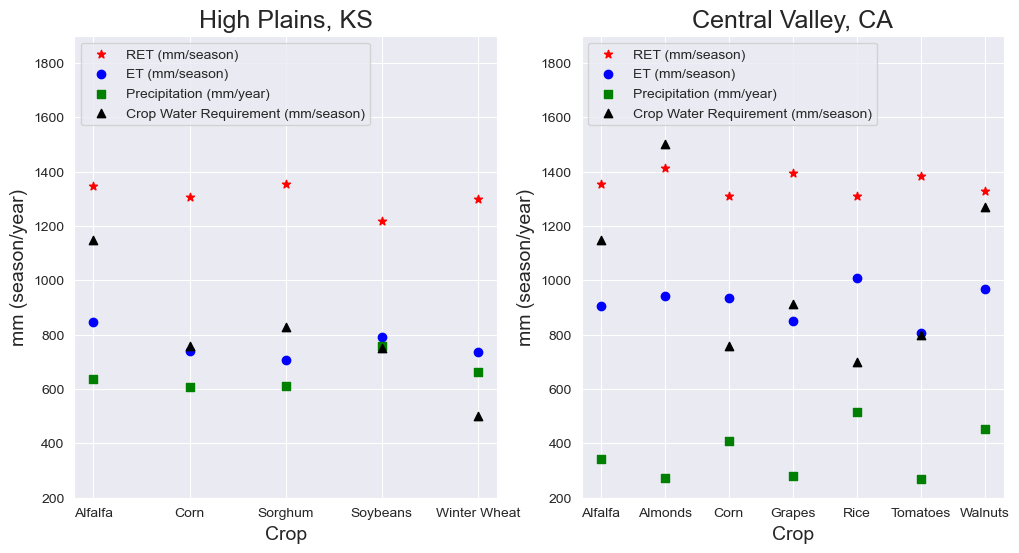

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.set_style("darkgrid")

# plotting KS
ax[0].scatter(summary_df_KS['Crop'], summary_df_KS['GRIDMET_RET']['median'], marker='*', color='r')
ax[0].scatter(summary_df_KS['Crop'], summary_df_KS['OpenET']['median'], marker='o', color='b')
ax[0].scatter(summary_df_KS['Crop'], summary_df_KS['PRISM_PPT']['median'], marker='s', color='g')
ax[0].scatter(summary_df_KS['Crop'], summary_df_KS['max_season_wrq'], marker="^", color='black')
ax[0].set_xlabel('Crop', fontsize=14)
ax[0].set_ylabel('mm (season/year)', fontsize=14)
ax[0].set_ylim(200, 1900)
ax[0].tick_params(axis='both', labelsize=10)
ax[0].legend(['RET (mm/season)', 'ET (mm/season)', 'Precipitation (mm/year)', 'Crop Water Requirement (mm/season)'], loc='upper left', fontsize=10)
ax[0].set_title('High Plains, KS', fontsize=18)

# plotting CA
ax[1].scatter(summary_df_CA['Crop'], summary_df_CA['GRIDMET_RET']['median'], marker='*', color='r')
ax[1].scatter(summary_df_CA['Crop'], summary_df_CA['OpenET']['median'], marker='o', color='b')
ax[1].scatter(summary_df_CA['Crop'], summary_df_CA['PRISM_PPT']['median'], marker='s', color='g')
ax[1].scatter(summary_df_CA['Crop'], summary_df_CA['max_season_wrq'], marker="^", color='black')
ax[1].set_xlabel('Crop', fontsize=14)
ax[1].set_ylabel('mm (season/year)', fontsize=14)
ax[1].set_ylim(200, 1900)
ax[1].tick_params(axis='both', labelsize=10)
ax[1].legend(['RET (mm/season)', 'ET (mm/season)', 'Precipitation (mm/year)', 'Crop Water Requirement (mm/season)'], loc='upper left', fontsize=10)
ax[1].set_title('Central Valley, CA', fontsize=18)

> - The difference between ET and precipitation in HPA, KS and CV, CA shows how much gap in crop water demand have to be filled by irrigation.

> - From plot of KS, it seems that the gap between precip, crop water demand,and ET of Corn and Soybeans are really close. This means precipitation has the capacity to fill entire demand. Corn and Soybeans are the major crops in South/North Dakotas' rainfed croplands. This might be the reason why South/North Dakota have high ET from Rainfed croplands.

In [42]:
data_parquet = '../../Data_main/Model_csv_v2/train_test.parquet'

df = pd.read_parquet(data_parquet)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../../Data_main/Model_csv_v2/train_test.parquet'

In [4]:
df.columns

Index(['Rainfed_cropET', 'year', 'month', 'MODIS_Day_LST', 'MODIS_LAI',
       'MODIS_NDVI', 'MODIS_NDWI', 'PRISM_Precip', 'PRISM_Tmax', 'PRISM_Tmin',
       'Ssebop_ETa', 'GRIDMET_RET', 'GRIDMET_vap_pres_def', 'GRIDMET_max_RH',
       'GRIDMET_min_RH', 'GRIDMET_wind_vel', 'GRIDMET_short_rad',
       'DAYMET_sun_hr', 'Rainfed_Frac', 'Bulk_density', 'Clay_content',
       'Field_capacity', 'Sand_content', 'Slope', 'Latitude', 'Longitude'],
      dtype='object')

In [5]:
len(df)

24411343

In [6]:
# Outlier detection using IQR
lower_range, upper_range, median = calc_outlier_ranges_IQR(data=df.Rainfed_cropET, axis=None, decrease_lower_range_by=None, increase_upper_range_by=None)
lower_range, upper_range, median

(0.0, 125.59185791015625, 26.732065200805664)

In [7]:
# Outlier detection using MAD
lower_range, upper_range, median = calc_outlier_ranges_MAD(data=df.Rainfed_cropET)
lower_range, upper_range, median

(-28.606000900268555, 82.07013130187988, 26.732065)

Looks like both IQR and MAD method can't detect outliers at low/high end. The upper thresholds these methods calculate isn't outlier as ET can be high. 

In [29]:
df_sel = df[(df['Rainfed_cropET'] > df['Ssebop_ETa']) & (df['Rainfed_cropET'] > df['PRISM_Precip'])]
df_sel = df_sel[['Ssebop_ETa', 'PRISM_Precip', 'month', 'Rainfed_cropET']]
df_sel

,Ssebop_ETa,PRISM_Precip,month,Rainfed_cropET
147268,0.0,4.976000,1,5.639647
147269,0.0,4.976000,1,6.669608
149124,0.0,7.029000,1,7.805893
149565,0.0,5.925000,1,5.985356
149612,0.0,8.099000,1,8.339729
...,...,...,...,...
24408736,153.0,120.694000,6,168.592133
24408758,131.0,97.389000,6,144.906158
24408759,145.0,120.694000,6,149.746719
24408784,147.0,117.989998,6,163.311829


In [30]:
df_sel['month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [31]:
len(df) - len(df_sel)

17239434